### Discussion 13.1: Using Logistic Regression to Make Business Decisions

<center>
    <img src = 'images/uci_biz.png' />
</center>



------------


For this try-it, you are to explore some available datasets related to business applications of classification.  Using a dataset from the UCI Machine Learning Repository, scan datasets   under the subject area "BUSINESS" [link here](https://archive.ics.uci.edu/datasets?skip=0&take=10&sort=desc&orderBy=NumHits&search=&Area=Business).  Find a dataset that looks interesting to you and decide how you could use Logistic Regression to help make a business decision using the data.

In sharing your results, be sure to clearly describe the following:

- the dataset and its features
- the classification problem -- what are you classifying here?
- a business decision that can be supported using the results of the classification model

Share your summary on the appropriate discussion board for the activity.


Nota that for this solution file the [Online Shoppers Purchasing Intention Dataset](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset) was used.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report


In [4]:
df = pd.read_csv('data/online_shoppers_intention.csv')

In [5]:
data_info = df.info()
data_head = df.head()
df.describe(), data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

(       Administrative  Administrative_Duration  Informational  \
 count    12330.000000             12330.000000   12330.000000   
 mean         2.315166                80.818611       0.503569   
 std          3.321784               176.779107       1.270156   
 min          0.000000                 0.000000       0.000000   
 25%          0.000000                 0.000000       0.000000   
 50%          1.000000                 7.500000       0.000000   
 75%          4.000000                93.256250       0.000000   
 max         27.000000              3398.750000      24.000000   
 
        Informational_Duration  ProductRelated  ProductRelated_Duration  \
 count            12330.000000    12330.000000             12330.000000   
 mean                34.472398       31.731468              1194.746220   
 std                140.749294       44.475503              1913.669288   
 min                  0.000000        0.000000                 0.000000   
 25%                  0.00000

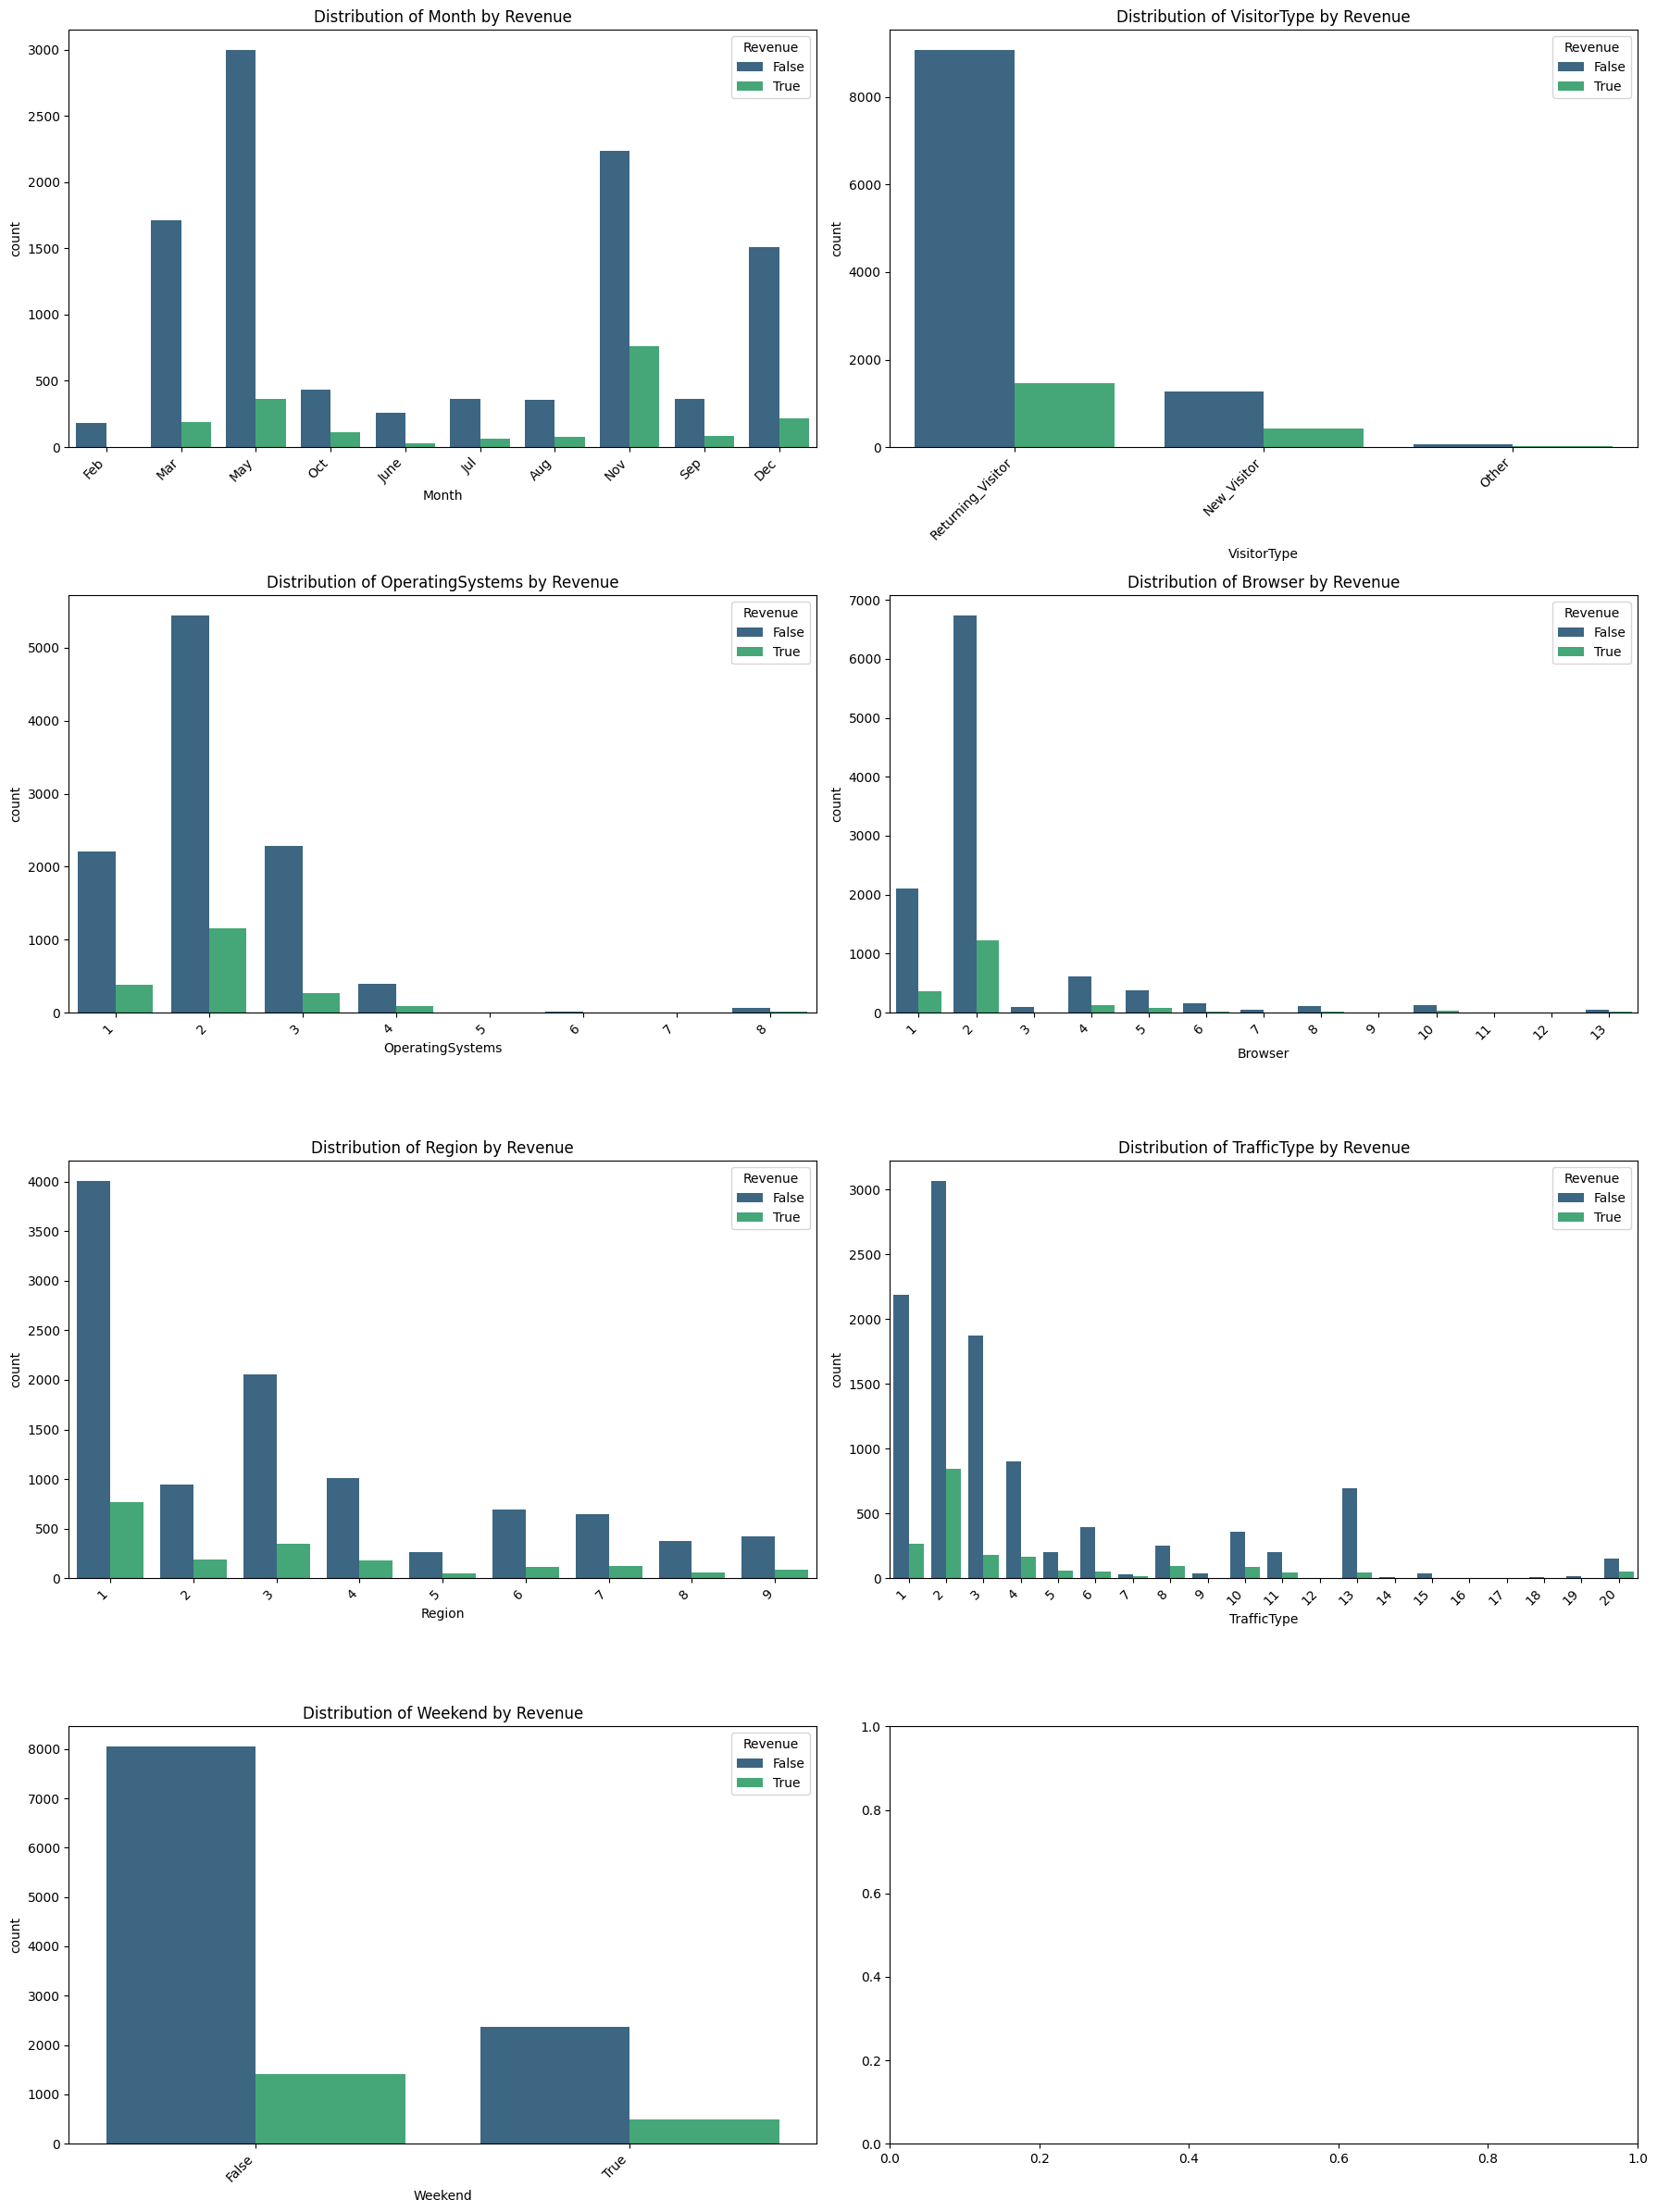

In [6]:
# Analyze the distribution of categorical features with respect to the target variable 'Revenue'
categorical_features = ['Month', 'VisitorType', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend']

# Set up the plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 24))
axes = axes.flatten()

# Plotting the distribution of each categorical feature with respect to Revenue
for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='Revenue', data=df, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {col} by Revenue')
    axes[i].legend(title='Revenue', loc='upper right')
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha="right")

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plots
plt.show()


C:\Users\prove\AppData\Local\Temp\ipykernel_23320\954102841.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


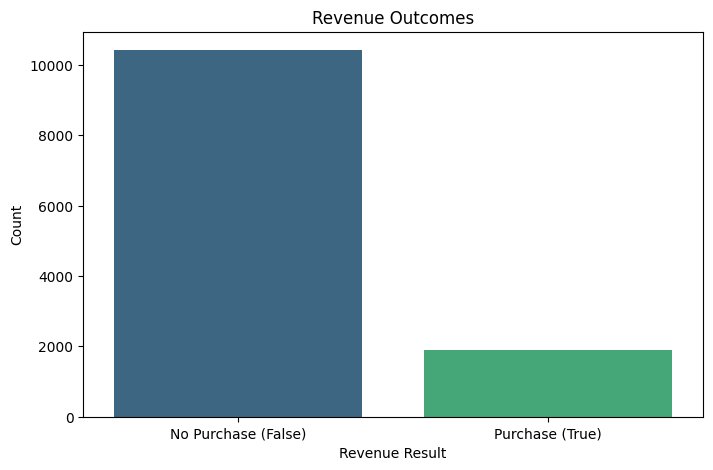

In [7]:
revenue_counts = {'False': 10422, 'True': 1908}

# Convert the dictionary to a suitable form for plotting
names = list(revenue_counts.keys())
values = list(revenue_counts.values())

# Create the plot
plt.figure(figsize=(8, 5))  # Adjust the size of the figure as needed
sns.barplot(x=names, y=values, palette="viridis")

plt.title('Revenue Outcomes')
plt.xlabel('Revenue Result')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Purchase (False)', 'Purchase (True)'])  # Making it clear what True and False mean
plt.show()

In [8]:
categorical_features = ['Month', 'VisitorType', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend']
numerical_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                      'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

# Create the preprocessing pipelines for both numerical and categorical data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle any potential missing values
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle any potential missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Create a full pipeline with classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Split data into features and target variable
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Fitting the model
pipeline.fit(X_train, y_train)

# Scoring the model
score = pipeline.score(X_test, y_test)

score

0.8813192754798594

In [9]:
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Calculate the mean and standard deviation of the cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

cv_mean, cv_std

(np.float64(0.8833738848337388), np.float64(0.007247722826520335))

### Logistic Regression Pipeline with optimal threshold

In [10]:
# Adjust the original pipeline to include a Logistic Regression classifier with class weight balancing
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))
])

# Fit the logistic regression model
logistic_pipeline.fit(X_train, y_train)

# Get the probabilities of the positive class for threshold adjustment
y_scores_logistic = logistic_pipeline.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds for the logistic model
precision_logistic, recall_logistic, thresholds_logistic = precision_recall_curve(y_test, y_scores_logistic)

# Find the optimal threshold, targeting a good balance of recall and precision
optimal_idx = np.argmax((recall_logistic * precision_logistic))
optimal_threshold = thresholds_logistic[optimal_idx]

# Adjust threshold for classification
y_pred_adjusted = (y_scores_logistic >= optimal_threshold).astype(int)

# Generate a classification report with the adjusted threshold
adjusted_report = classification_report(y_test, y_pred_adjusted, target_names=['Non-Purchase', 'Purchase'])

print(adjusted_report)
optimal_threshold

              precision    recall  f1-score   support

Non-Purchase       0.94      0.91      0.92      3127
    Purchase       0.58      0.70      0.63       572

    accuracy                           0.87      3699
   macro avg       0.76      0.80      0.78      3699
weighted avg       0.89      0.87      0.88      3699



np.float64(0.5664897053398074)

### Default Threshold

In [12]:
from sklearn.metrics import classification_report

# Refit the balanced pipeline on the full training set
logistic_pipeline.fit(X_train, y_train)

# Predictions on the test set
y_pred = logistic_pipeline.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['Non-Purchase', 'Purchase'])

print(report)


              precision    recall  f1-score   support

Non-Purchase       0.95      0.87      0.91      3127
    Purchase       0.51      0.75      0.61       572

    accuracy                           0.85      3699
   macro avg       0.73      0.81      0.76      3699
weighted avg       0.88      0.85      0.86      3699



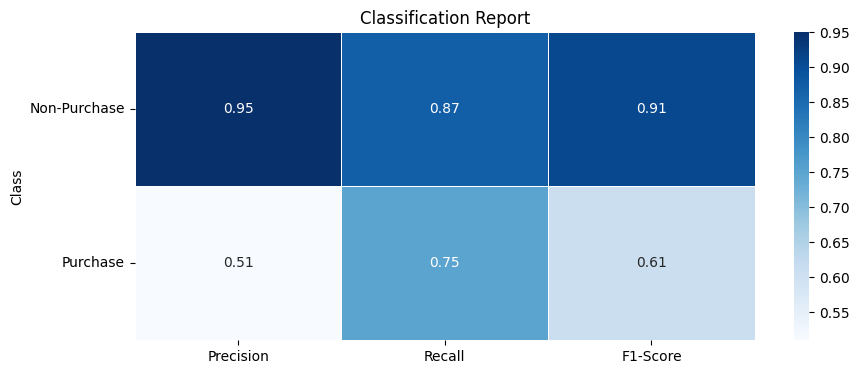

In [13]:
data = {
    'Precision': [0.95, 0.51],  # Updated precision scores
    'Recall': [0.87, 0.75],     # Updated recall scores
    'F1-Score': [0.91, 0.61]    # Updated F1-scores
}
classes = ['Non-Purchase', 'Purchase']

# Create a DataFrame
df = pd.DataFrame(data, index=classes)

# Plotting
plt.figure(figsize=(10, 4))
sns.heatmap(df, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Classification Report')
plt.ylabel('Class')
plt.yticks(rotation=0)  # Keep the class names horizontal

# Display the plot
plt.show()

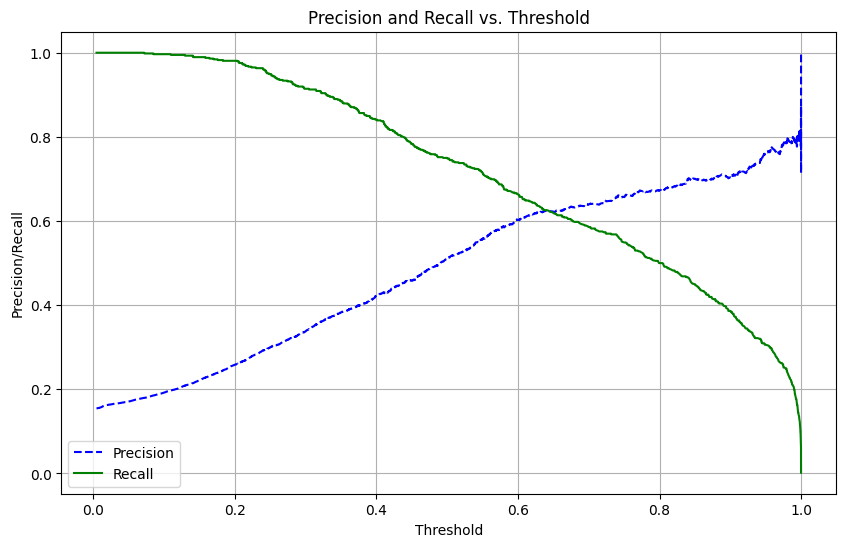

In [15]:
y_scores = logistic_pipeline.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Re-defining the numerical and categorical features for clarity
numerical_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                      'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

categorical_features = ['Month', 'VisitorType', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend']

# Extracting feature names from the preprocessor in the pipeline for categorical features
ohe_feature_names = list(logistic_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
                         .get_feature_names_out(categorical_features))

# Combine all feature names
all_feature_names = numerical_features + ohe_feature_names

# Extracting coefficients from the logistic regression model
coefficients = logistic_pipeline.named_steps['classifier'].coef_[0]

# Creating a DataFrame to view feature importances (coefficients)
feature_importance = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})

# Sorting features by the absolute values of their coefficients for better visualization
feature_importance_sorted = feature_importance.reindex(feature_importance.Coefficient.abs().sort_values(ascending=False).index)

feature_importance_sorted.head(10)


,Feature,Coefficient
8,PageValues,2.339298
42,Browser_12,1.741114
28,OperatingSystems_6,-1.168007
68,TrafficType_16,1.155367
12,Month_Feb,-1.106066
67,TrafficType_15,-1.085360
37,Browser_7,-1.065346
17,Month_Nov,0.732479
29,OperatingSystems_7,0.709562
7,ExitRates,-0.611737
